## Dataset description
In the figure of the experimental setup (see CWRU website), motor is at the left. Faulty bearings with known fault depth (0.007 inch, or 0.014 inch, or 0.021 inch) are installed in the motor and the resulting vibration signal is collected by accelerometers. Accelerometers are placed at three locations of the motor: at the drive end (DE), fan end (FE) and base (BA). The end of the motor connected to the rotor shaft is called drive end. The other end is called fan end. It is called fan end because almost every induction motor has a fan at that side. The purpose of the fan is to cool the motor. Base is the support over which the motor is mounted. So accelerometers are placed at these three locations and resulting time series data are collected with a sampling frequency of either 12k or 48k. Sampling frequency is nothing but how many data points we collect in a second. So a sampling frequency of 48k means that the sensor will collect 48000 data points per second. If our data file contains 4800000 data points for example, then that would mean we have collected data for 100 seconds at a sampling frequency of 48k.

In the experiment, different amounts of (torsional) loads are applied to the motor. In all of our experiments we have taken data with 1hp load and 48k sampling frequency. Data files are originally stored in `.mat` format. `.mat` is the default format of data storage in `MATLAB`. `MATLAB` is heavily used in engineering disciplines. So several public mechanical datasets are stored in `.mat` format. It just makes it easy to load the data into `MATLAB` and do further analysis. In python, we can read `.mat` files using `scipy` library.

In [ ]:
import glob
from scipy.io import loadmat
import numpy as np

To reiterate, in our analysis we have used data with 1hp load and 48k sampling frequency. We can download the files from the website and put those in one folder. In our case, the folder is `/home/biswajit/data/cwru/`. In the website, the data are stored using numbers as file names. For example, Ball defect of 0.007 inch depth and 1hp load is stored as `123.mat`. Similarly for other files. We have appended the fault type, its depth and load information to each file name after downloading for convenience. For Normal file, I have appended "Time" to the left. I have done so to make it the last entry of the sorted list. 

In [1]:
files = glob.glob("cwru/*")
files = np.sort(files)
files

NameError: name 'glob' is not defined

In [ ]:
# # 把這個資料夾裡頭所有 .mat (包括所有子資料夾, 用 os walk) 的文件路徑給儲存成一個 list
# import os

# files = []
# for root, dirs, files_ in os.walk('cwru-data'):
#     for file in files_:
#         if file.endswith('.mat'):
#             files.append(os.path.join(root, file))
# files

In [ ]:
# files.sort()

While reading each mat files using `loadmat` function of `scipy`, the result is a dictionary. Its keys give us the data.

In [ ]:
check_data = loadmat(files[0])
type(check_data)

dict

In [ ]:
check_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X123_DE_time', 'X123_FE_time', 'X123RPM'])

Keys of each file contain drive end signal (DE_time), fan end signal (FE_time), and in some cases base signal (BA).
`X123RPM` gives RPM information.
**We will only take drive end data for our analysis.**
Drive ends are closer to the bearing.
So we believe, it would give more reliable indication of fault.
Thus, we have used only drive end data.
We can get drive end data using its key.

In [ ]:
drive_end_data = check_data["X123_DE_time"]
drive_end_data.shape

(487384, 1)

Of all the files in the folder, one file (`IR014_1_175.mat`) is rather peculiar. It has following keys: `'X217'`, `'X217_DE_time'`, `'X175_DE_time'`, `'X175_FE_time'`, `'X175RPM'`. `'X175_DE_time'` contains less number of data points than we need for further analysis. So we have taken `'X217_DE_time'` for this particular file.

In [8]:
check_data_2 = loadmat(files[4])
check_data_2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X217', 'X217_DE_time', 'X175_DE_time', 'X175_FE_time', 'X175RPM'])

## 資料預處理
在深度學習時代之前，分析原始數據以獲得結果相當困難。因此，人們使用基於經典特徵的技術進行故障診斷。在基於特徵的技術中，首先從數據中收集相關的特徵。特徵可以分為時域特徵、頻域特徵或時頻域特徵。

時域特徵包括：

- 信號的最大值，
- 信號的最小值，
- 根均方根（RMS）值，
- 或者像
  - 偏度，
  - 峰度等統計特徵。

這些被稱為時域特徵，因為這些特徵是從時域數據計算出來的。

有時，將數據轉換到頻域（通過進行快速傅里葉變換）並從頻域信號中收集特徵會更有益。在這種情況下，這些特徵被稱為頻域特徵。這些特徵通常是轉動頻率和其倍數的頻率振幅值。

數據的另一種有用的轉換是時頻轉換。語音圖給我們提供了時頻表示。另一種時頻轉換是通過小波轉換得到。小波轉換後，我們可以收集像“小波包能量”和“小波包熵”這樣的特徵。這是我們在實驗中大量使用的特徵類型。結果顯示，這些特徵大多對振動信號有很好的結果。但缺點是計算這些特徵的成本相對較高。

現在，要計算時域特徵，我們可以取整個信號或其部分。如果我們取整個信號並計算，比如說8個特徵，它將給我們8個數字。這8個數字太少，無法代表超過480000個數據點。一個更好的選擇是將原始數據分割成長度為1024或2048的段，並且相鄰段之間沒有重疊。這將給我們更多的段，希望以更好的方式代表原始數據。

所以首先，讓我們計算從每個文件中可以提取的最大數量的1024長度段。我們將只使用駕駛端數據。

### Number of segments from each file

In [9]:
# import re
# pattern = re.compile(r"\d{2,3}")

# for file in files:
#     data = loadmat(file)
#     # print(data)
#     if file[-7:-4] == "175":         # Peculiar IR014_1 data
#         key = "X217_DE_time"
#     else:
#         key = "X" + file[-7:-4] + "_DE_time"
#     try:
#         drive_end_data = data[key]
#         num_segments = np.floor(len(drive_end_data)/1024)
#         print(num_segments)
#     except KeyError:
#         print("KeyError: ", key)

In [10]:
for file in files:
    data = loadmat(file)
    # print(data)
    if file[-7:-4] == "175":         # Peculiar IR014_1 data
        key = "X217_DE_time"
    else:
        key = "X" + file[-7:-4] + "_DE_time"
    drive_end_data = data[key]
    num_segments = np.floor(len(drive_end_data)/1024)
    print(num_segments)

475.0
474.0
475.0
474.0
477.0
473.0
475.0
473.0
477.0
472.0


所以我們至少可以從每個檔案中提取出470個片段。
在處理數據時，只取了每個檔案的前460個片段。
提取後，我們的數據大小將是$(4600 \times 1024)$。
如果我們想要收集特徵，我們可以針對這些數據的每一行收集特徵。
例如，如果我們為每個片段收集8個時域特徵，那麼我們的特徵矩陣將有$(4600 \times 8)$的形狀。
這裡我們不會計算特徵。
而是只是建立一個預處理數據矩陣。

In [11]:
segmented_data = np.repeat(np.nan, 4600*1024).reshape(4600,1024)
num = 0
for file in files:
    data = loadmat(file)
    if file[-7:-4] == "175":    
        key = "X217_DE_time"
    else:
        key = "X" + file[-7:-4] + "_DE_time"
    drive_end_data = data[key]
    for i in range(460):           # We collect 460 segments from each file
        try:
            segmented_data[num,:] = drive_end_data[i*1024:(i+1)*1024, 0]
        except:
            print("Error: ", file, i)
        num = num + 1

Check whether `segmented_data` contains any `nan` values or not.

In [12]:
np.sum(np.isnan(segmented_data))

0

In [13]:
segmented_data.shape

(4600, 1024)

In [14]:
_segmented_data = segmented_data.reshape(4600, 32, 32)

For comparison, first download the processed data available online at [this link](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/data/CWRU_48k_load_1_CNN_data.npz). Load the data and then compare it with previously prepared "segmented_data".

In [15]:
read_online_data = np.load("data/CWRU_48k_load_1_CNN_data.npz")
read_online_data.files

['data', 'labels']

In [16]:
read_online_data['labels']

array(['Ball_007', 'Ball_007', 'Ball_007', ..., 'Normal', 'Normal',
       'Normal'], dtype='<U8')

In [17]:
online_data = read_online_data["data"]
online_data.shape

(4600, 32, 32)

In [18]:
np.sum(1-np.isclose(online_data, _segmented_data, atol = 1e-4))

0

In [19]:
online_data[0]

array([[-0.041097 , -0.046104 , -0.028372 , ..., -0.042975 , -0.11453  ,
        -0.17711  ],
       [-0.23052  , -0.26348  , -0.26077  , ..., -0.023782 , -0.11787  ,
        -0.18775  ],
       [-0.20882  , -0.19297  , -0.15208  , ..., -0.017524 , -0.063628 ,
        -0.11411  ],
       ...,
       [ 0.02253  , -0.049859 , -0.11098  , ..., -0.036508 , -0.03317  ,
        -0.02858  ],
       [-0.0031292,  0.030249 ,  0.063419 , ..., -0.035882 , -0.010014 ,
         0.030875 ],
       [ 0.06029  ,  0.072598 ,  0.076145 , ...,  0.13602  ,  0.10139  ,
         0.066548 ]])

In [20]:
_segmented_data[0]

array([[-0.04109723, -0.046104  , -0.02837169, ..., -0.04297477,
        -0.11452985, -0.17711446],
       [-0.23052   , -0.26348123, -0.26076923, ..., -0.02378215,
        -0.11786769, -0.18775385],
       [-0.208824  , -0.19296923, -0.15208062, ..., -0.01752369,
        -0.06362769, -0.11411262],
       ...,
       [ 0.02253046, -0.04985908, -0.11098338, ..., -0.03650769,
        -0.03316985, -0.02858031],
       [-0.00312923,  0.03024923,  0.06341908, ..., -0.03588185,
        -0.01001354,  0.03087508],
       [ 0.06028985,  0.07259815,  0.07614462, ...,  0.13601723,
         0.10138708,  0.06654831]])

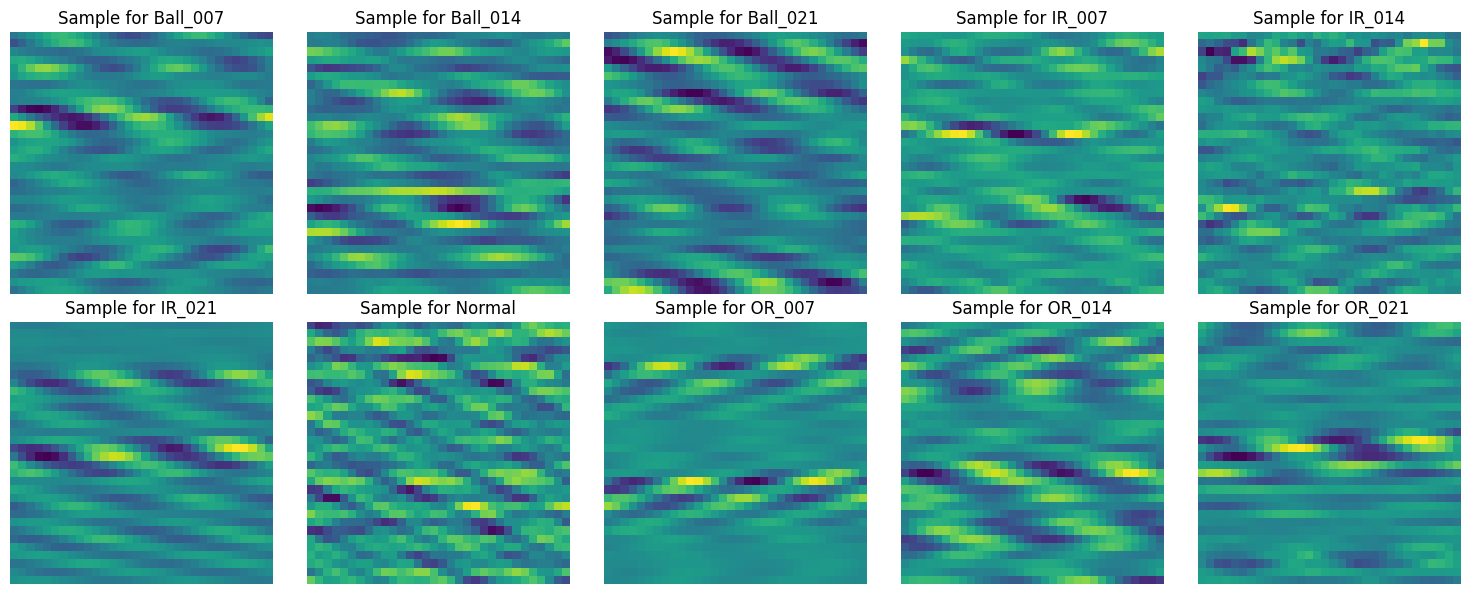

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 讀取資料
read_online_data = np.load("data/CWRU_48k_load_1_CNN_data.npz")
data = read_online_data['data']
labels = read_online_data['labels']

# 取得所有 unique 的 label
unique_labels = np.unique(labels)

# 創建一個字典來存儲每個類別的隨機樣本
samples = {}

# 對每個 unique label 選擇一個隨機樣本
for label in unique_labels:
    # 找到這個 label 的索引
    indices = np.where(labels == label)[0]
    # 隨機選擇一個索引
    random_index = np.random.choice(indices)
    # 取得該索引對應的數據
    samples[label] = data[random_index]

# 設定子圖大小（假設最多 10 個類別）
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))

# 如果唯一標籤數少於 10，補充空白子圖
axes = axes.flatten()

# 繪製每個類別的隨機樣本
for i, label in enumerate(unique_labels):
    ax = axes[i]
    ax.imshow(samples[label], cmap='viridis')
    ax.set_title(f"Sample for {label}")
    ax.axis('off')

# 隱藏多餘的子圖
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

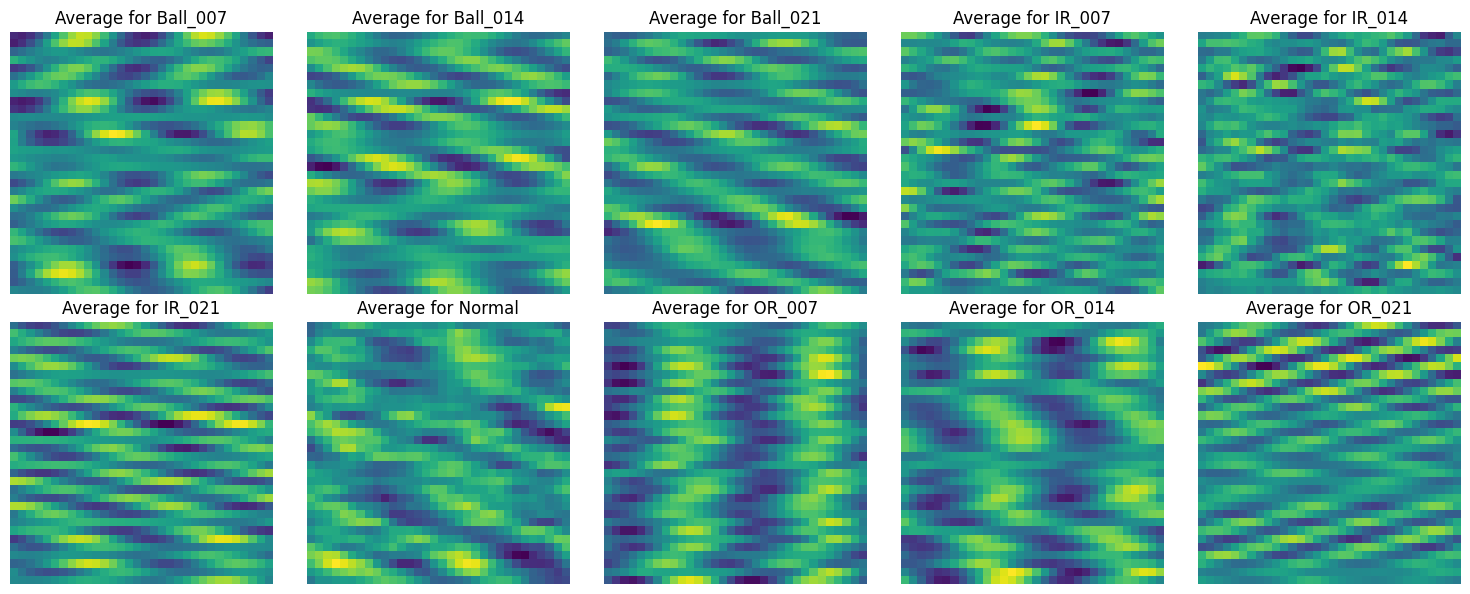

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 讀取資料
read_online_data = np.load("data/CWRU_48k_load_1_CNN_data.npz")
data = read_online_data['data']
labels = read_online_data['labels']

# 取得所有 unique 的 label
unique_labels = np.unique(labels)

# 創建一個字典來存儲每個類別的平均資料
averages = {}

# 對每個 unique label 計算平均
for label in unique_labels:
    # 找到這個 label 的索引
    indices = np.where(labels == label)[0]
    # 根據這些索引從 data 中選出相對應的資料
    class_data = data[indices]
    # 計算每個類別的平均
    averages[label] = np.mean(class_data, axis=0)

# 計算需要的子圖大小，這裡設為 2x5，並確保有足夠的子圖
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))

# 如果唯一標籤數少於 10，補充空白子圖
axes = axes.flatten()

# 繪製每個類別的平均圖
for i, label in enumerate(unique_labels):
    ax = axes[i]
    ax.imshow(averages[label], cmap='viridis')
    ax.set_title(f"Average for {label}")
    ax.axis('off')

# 如果子圖多餘的話，隱藏它們
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

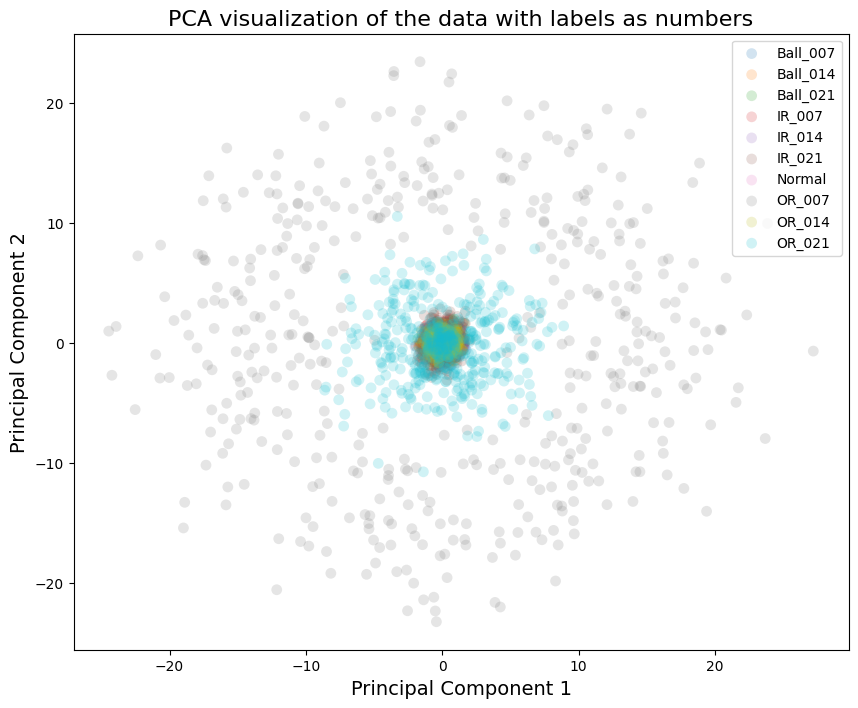

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.cm as cm

# 讀取資料
read_online_data = np.load("data/CWRU_48k_load_1_CNN_data.npz")
data = read_online_data['data']
labels = read_online_data['labels']

# 重塑資料為 2D 陣列，(4600, 1024)
data_reshaped = data.reshape(data.shape[0], -1)

# 使用 LabelEncoder 將 labels 轉換為數字
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 使用 PCA 進行降維，將資料降至 2 維
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_reshaped)

# 獲取每個類別的顏色
unique_labels = np.unique(labels_encoded)
colors = cm.tab10(np.linspace(0, 1, len(unique_labels)))

# 增大圖片尺寸，使其足夠清晰
plt.figure(figsize=(10, 8))

# 針對每個 label，繪製不同顏色的資料點
for i, label in enumerate(unique_labels):
    indices = np.where(labels_encoded == label)
    plt.scatter(data_pca[indices, 0], data_pca[indices, 1], label=label_encoder.inverse_transform([label])[0], 
                color=colors[i], alpha=0.2, edgecolors='None', s=60)

# 設定標題和軸標籤
plt.title('PCA visualization of the data with labels as numbers', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)

# 顯示圖例
plt.legend()

plt.show()

In [34]:
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# 讀取資料
read_online_data = np.load("data/CWRU_48k_load_1_CNN_data.npz")
data = read_online_data['data']
labels = read_online_data['labels']

# 重塑資料為 2D 陣列
data_reshaped = data.reshape(data.shape[0], -1)

# 使用 LabelEncoder 將 labels 轉換為數字
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_str = label_encoder.inverse_transform(labels_encoded)  # 轉回原始標籤

# 使用 PCA 進行降維
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_reshaped)

# 將結果存入 DataFrame
data_dict = {
    "Principal Component 1": data_pca[:, 0],
    "Principal Component 2": data_pca[:, 1],
    "Label": labels_str
}

# 指定要 **初始顯示** 的 Label（這裡選擇第一個類別）
initial_label = 'Normal'
# labels_str[3]

# 使用 plotly.express 建立互動式散點圖
fig = px.scatter(
    data_dict,
    x="Principal Component 1",
    y="Principal Component 2",
    color="Label",
    title="PCA visualization of the data",
    opacity=0.7
)

# 隱藏所有 trace，僅顯示 `initial_label`
for trace in fig.data:
    if trace.name != initial_label:
        trace.visible = "legendonly"  # 初始隱藏，點擊圖例後顯示

# 顯示圖表
fig.show()

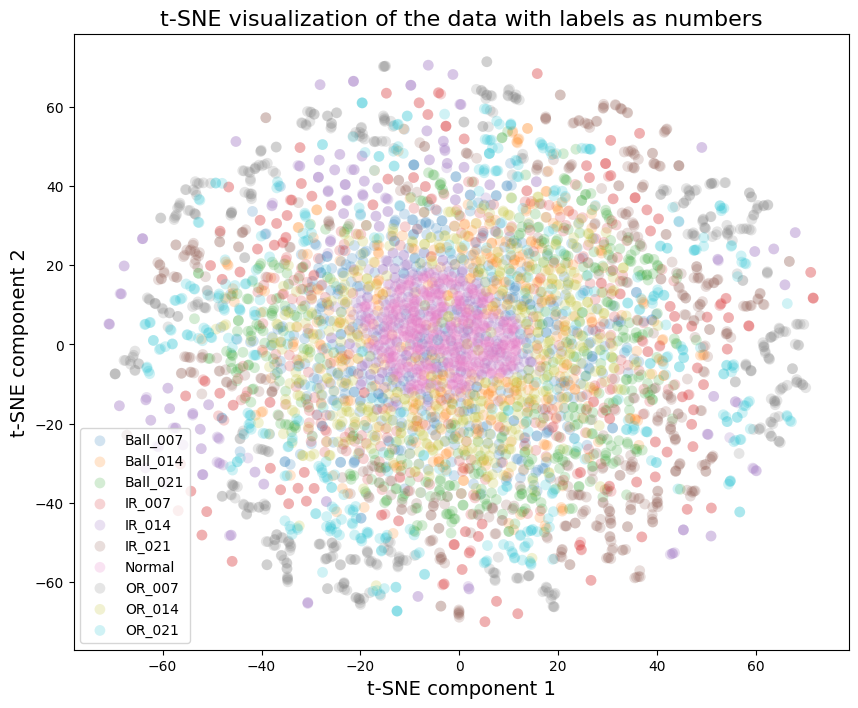

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.cm as cm

# 讀取資料
read_online_data = np.load("data/CWRU_48k_load_1_CNN_data.npz")
data = read_online_data['data']
labels = read_online_data['labels']

# 重塑資料為 2D 陣列，(4600, 1024)
data_reshaped = data.reshape(data.shape[0], -1)

# 使用 LabelEncoder 將 labels 轉換為數字
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 使用 t-SNE 進行降維，將資料降至 2 維
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_reshaped)

# 獲取每個類別的顏色
unique_labels = np.unique(labels_encoded)
colors = cm.tab10(np.linspace(0, 1, len(unique_labels)))

# 增大圖片尺寸，使其足夠清晰
plt.figure(figsize=(10, 8))

# 針對每個 label，繪製不同顏色的資料點
for i, label in enumerate(unique_labels):
    indices = np.where(labels_encoded == label)
    plt.scatter(data_tsne[indices, 0], data_tsne[indices, 1], label=label_encoder.inverse_transform([label])[0], 
                # color=colors[i], alpha=0.3, edgecolors='k', s=60)
                color=colors[i], alpha=0.2, edgecolors='none', s=60)

# 設定標題和軸標籤
plt.title('t-SNE visualization of the data with labels as numbers', fontsize=16)
plt.xlabel('t-SNE component 1', fontsize=14)
plt.ylabel('t-SNE component 2', fontsize=14)

# 顯示圖例
plt.legend()

plt.show()

In [36]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# 讀取資料
read_online_data = np.load("data/CWRU_48k_load_1_CNN_data.npz")
data = read_online_data['data']
labels = read_online_data['labels']

# 重塑資料為 2D 陣列，(4600, 1024)
data_reshaped = data.reshape(data.shape[0], -1)

# 使用 LabelEncoder 將 labels 轉換為數字
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_str = label_encoder.inverse_transform(labels_encoded)  # 轉回原始標籤

# 使用 t-SNE 進行降維，將資料降至 2 維
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_reshaped)

# 將結果存入 DataFrame
data_dict = {
    "t-SNE Component 1": data_tsne[:, 0],
    "t-SNE Component 2": data_tsne[:, 1],
    "Label": labels_str
}

# 使用 plotly.express 建立互動式散點圖
fig = px.scatter(
    data_dict,
    x="t-SNE Component 1", 
    y="t-SNE Component 2", 
    color="Label",
    title="t-SNE visualization of the data",
    opacity=0.6
)

# 指定要 **初始顯示** 的 Label（這裡選擇第一個類別）
initial_label = 'Normal'
# 隱藏所有 trace，僅顯示 `initial_label`
for trace in fig.data:
    if trace.name != initial_label:
        trace.visible = "legendonly"  # 初始隱藏，點擊圖例後顯示

# 顯示圖表
fig.show()


The online data has few significant digits.
This is because it was prepared first by extracting data from `mat` files and saving it in `csv` files.
Those `csv` files were then used to load data and ultimately save it in `npz` format.


Now if we want to compute features, we can compute it using segmented data.
Steps to [compute time domain features](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/Calculating_time_domain_features_CWRU.ipynb) are explained in [this notebook](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/Calculating_time_domain_features_CWRU.ipynb).
In my [project page](https://biswajitsahoo1111.github.io/cbm_codes_open/), I have also mentioned ways to compute wavelet packet features ([wavelet packet energy](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/calculate_wavelet_packet_energy_features.ipynb) as well as [wavelet packet entropy](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/calculate_wavelet_packet_entropy_features.ipynb)).
We can also apply deep learning techniques to the segmented time domain data without computing any features what so ever.
[This notebook](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/Deep_learning_based_fault_diagnosis_using_CNN_on_raw_time_domain_data.ipynb) applies convolutional neural network (CNN) to time domain data of the present notebook and achieves **98.7%** overall accuracy.